# High-level interface

Our data is in 216 blocks of 1024 x 1024 x 1024 voxels. It would be real nice to be able to manipulate the full volume using a high-level interface. We will lazily assemble a volume out of the 216 blocks and do a simple operation: we will visualize one neuron. We will find all voxels that match the target neuron id and count their numbers along the z axis using a reduction. This will give us the outline of the cell via an orthographic projection.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import collections
import dask
import gcsfs
import h5py
import io
import numba
import numpy as np
import os
import os.path
import pickle
import requests

import os.path
import dask.array as da
import xarray as xr

from dask.distributed import Client
from dask_kubernetes import KubeCluster
from numba.typed import Dict

In [2]:
with open('../.gcs_tokens', 'rb') as f:
    credentials = pickle.load(f)
credentials = credentials[list(credentials.keys())[0]]
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
fs.ls('l4dense/neuron-volume')[:10]

['l4dense/neuron-volume/x4y7z0.hdf5',
 'l4dense/neuron-volume/x1y0z2.hdf5',
 'l4dense/neuron-volume/x4y6z2.hdf5',
 'l4dense/neuron-volume/x3y6z3.hdf5',
 'l4dense/neuron-volume/x5y2z2.hdf5',
 'l4dense/neuron-volume/x2y2z0.hdf5',
 'l4dense/neuron-volume/x0y2z0.hdf5',
 'l4dense/neuron-volume/x3y8z0.hdf5',
 'l4dense/neuron-volume/x5y3z0.hdf5',
 'l4dense/neuron-volume/x2y1z0.hdf5']

# Transform to zarr

Currently, the data is in the form of hdf5 chunks. We want to transform it so it can easily be read in the cloud in the chunked format. We follow a similar scheme to https://pangeo.io/data.html:

1. We locally mirror the data
2. We save it as a zarr
3. We upload it to the cloud (GCS)

In step 2, I've had better luck with using defered computation (`compute=False`) as well as metadata consolidation (`consolidated=True`); eager computation led to out of memory errors and my kernel died. YMMV.

Importantly, we will do this locally with one worker thread (multiple local threads give me killed worker errors; multiple remote threads also crash because they don't have a local mirror of the data). Once we upload the zarr to the cloud, we will be able to manipulate it without pulling it locally directly, which will be really useful.

### Why not use the hdf5 files directly with GCS?

I haven't figured out how to mix:

* h5py
* gcs
* lazily evaluated dask arrays

The workers die when I try to do this. Therefore, I resorted to pulling the data first and transforming to zarr. zarr is GCS-aware. This solution is inelegant but it's what's recommended in Pangeo's docs. 

One alternative avenue may be to use FUSE to mount our GCS volume locally, which from h5py's perspective would remove gcs out of the equation. We would have to do this for each of our workers if we wanted to do this in parallel. I haven't figured out how to do this.

In [3]:
def locally_cache(filename, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'{filename}', 'rb') as f:
        data = f.read()
    
    try:
        dirname = '../cache/' + os.path.dirname(filename)
        os.makedirs(dirname)
    except FileExistsError:
        pass
    
    with open(f'../cache/{filename}', 'wb') as f:
        f.write(data)
    return len(data)

for d in fs.ls('l4dense/neuron-volume'):
    locally_cache(d, credentials)

In [ ]:
z = []
for k in range(4):
    y = []
    for j in range(9):
        x = []
        for i in range(6):
            fn = f'x{i}y{j}z{k}.hdf5'
            fullname = f'../cache/l4dense/neuron-volume/{fn}'
            f = open(fullname, 'rb')
            g = h5py.File(f, 'r')
            d = g['/data']
            array = da.transpose(da.from_array(d, chunks=(1024, 1024, 1024)), [2, 1, 0])
            x.append(array)
        xs = da.concatenate(x, axis=0)
        y.append(xs)
    ys = da.concatenate(y, axis=1)
    z.append(ys)
zs = da.concatenate(z, axis=2)

my_dataarray = xr.Dataset({'neuron_labels': (['x', 'y', 'z'], zs)})
base = '/tmp/zarr6'
computation = my_dataarray.to_zarr(base, consolidated=True, compute=False)
computation.compute()

Now perform the computation.

In [ ]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)

for root, _, filenames in os.walk(base):
    for filename in filenames:
        rel_root = root[len(base):]
        with open(f'{root}/{filename}', 'rb') as f:
            data = f.read()
        
        write_filename = f'l4dense/neuron-zarr-7{rel_root}/{filename}'
        with fs.open(write_filename, 'wb') as f:
            f.write(data)

# Read zarr data from the cloud

Now that we've saved our data to the cloud in the zarr format, we can read it back transparently.

In [4]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
gcsmap = gcsfs.mapping.GCSMap('l4dense/neuron-zarr-7', gcs=fs, check=True, create=False)

# read it back
ds_gcs = xr.open_zarr(gcsmap)

In [5]:
ds_gcs

<xarray.Dataset>
Dimensions:        (x: 6144, y: 9216, z: 4096)
Dimensions without coordinates: x, y, z
Data variables:
    neuron_labels  (x, y, z) uint8 dask.array<chunksize=(1024, 1024, 1024), meta=np.ndarray>

That is one big dataset! Do something simple - find all the voxels with a non-zero label, and count them across a thin stack (500 voxels high = 14 um along the z axis). This will give us a slice of the data, similar to what you might get with 2 photon imaging.

In [6]:
cluster = KubeCluster.from_yaml('worker-spec.yml')
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.36.0.89:41639
distributed.scheduler - INFO -   dashboard at:                     :8787


In [7]:
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-38a8432c-3d31-11ea-804d-2297d151a8a2
distributed.core - INFO - Starting established connection


In [8]:
ds_gcs.neuron_labels

<xarray.DataArray 'neuron_labels' (x: 6144, y: 9216, z: 4096)>
dask.array<zarr, shape=(6144, 9216, 4096), dtype=uint8, chunksize=(1024, 1024, 1024), chunktype=numpy.ndarray>
Dimensions without coordinates: x, y, z

In [9]:
computation = (ds_gcs.neuron_labels.sel(z=slice(2000, 2500)) > 0).sum(dim='z')
top_down_view = computation.compute()
computation

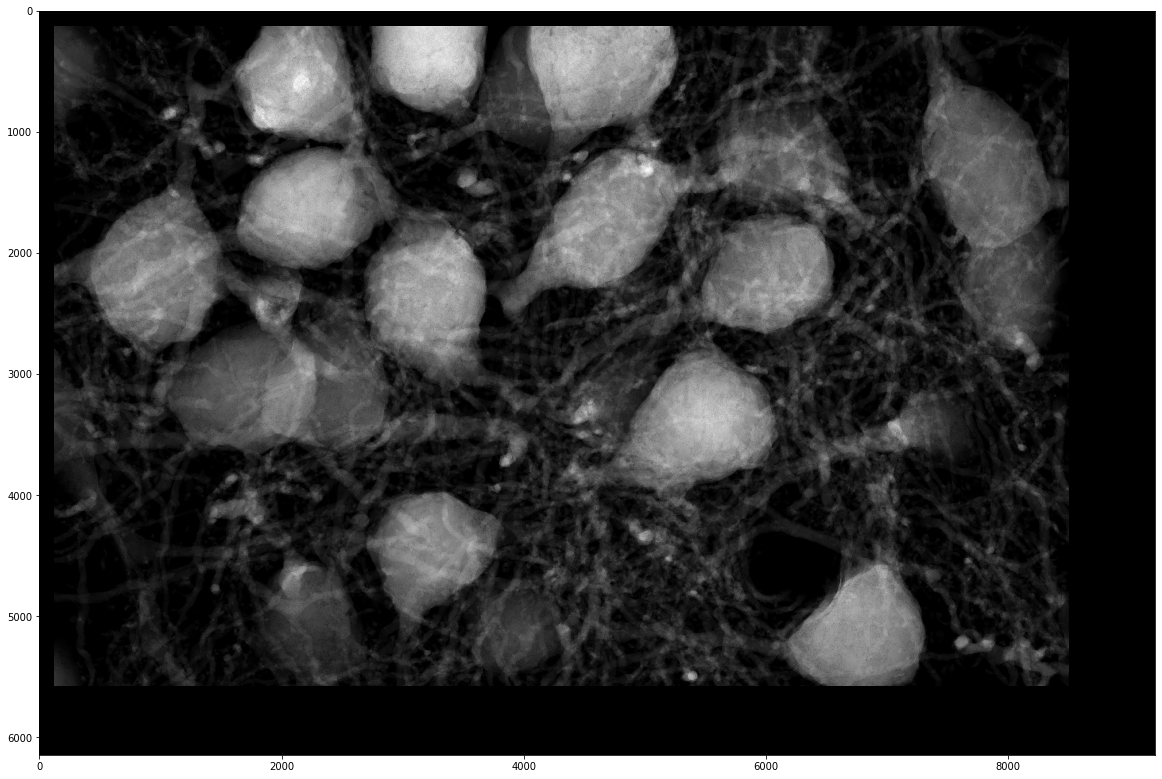

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(top_down_view, cmap='gray')